# Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond

In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents

In [29]:
from __future__ import division

import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
from helper2 import make_gif
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

4


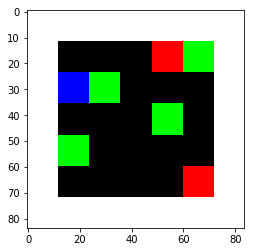

In [30]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)
print(env.actions)

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network itself

In [31]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay

This class allows us to store experies and sample then randomly to train the network.

In [32]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

This is a simple function to resize our game frames.

In [33]:
def processState(states):
    return np.reshape(states,[21168])

These functions allow us to update the parameters of our target network with those of the primary network.

In [34]:
def updateTargetGraph(tfVars,tau):
    #tfVars are all the trainable values of the computation graph, e.i. all the weights of the networks (main and target)
    #tau is the the ratio to which we update the Target network with respect to the Main network
    total_vars = len(tfVars)
    op_holder = []
    #Here we need to understand the structure of the tfVars array.
    #The first half entries are the trainable values of the Main Network
    #The last half entries are the trainable values of the Main Network
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        #New_targetNet_values = tau * New_MainNet_values + (1 - tau) * Old_MainNet_values
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

#This function just runs the session to compute the above expression
def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Training the network

Setting all the training parameters

In [35]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network
saveframes = True


In [ ]:

if saveframes == True:
    if not os.path.exists('./DDDQNframes'):
        os.makedirs('./DDDQNframes')
        
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

#trainable variables of the Main Network and the Target Network
trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episodes
jList = []
rList = []
total_steps = 0


#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        #GAther episode frames to create gifs eventuly
        episode_frames = []
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0] #Feed through main network to predict action
            s1,r,d = env.step(a)
            episode_frames.append(s1)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop #epsilon annealing
                
                if total_steps % (update_freq) == 0:
                    #Get a random batch of experiences from the episode buffer
                    trainBatch = myBuffer.sample(batch_size)
                    
                    #Below we perform the Double-DQN update to the target Q-values
                    
                    #First we calculate the best actions for state s1 in each experience of the batch using our Main Network
                    A = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    #Then we calculate the Qvalues for every selected experiences in the batch using our Target Network.
                    #So Q2 is a 2D-array containing a vector of Q-values for each randomly selected experiences in the batch
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    #the end multiplier goes to zero if the experience is an "end of game", so the target Q-value = the reward
                    end_multiplier = -(trainBatch[:,4] - 1) 
                    
                    #doubleQs are the Q-values estimated from Q2 at state s1 given action A = argmax(Q1(s1,:)). 
                    #So doubleQ is a vector containing the estimated Q-values for the best action possible 
                    #for each randomly selected experience in the batch.
                    doubleQ = Q2[range(batch_size),A]
                    
                    # Target-Q = r + gamma*(doubleQ) for non "end-of-game" experiences. Otherwise Target-Q = Reward
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    
                    #Update the Main network with our target Q-values.
                    _ = sess.run(mainQN.updateModel, \
                                   #loss function to optimize                    
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    #Update the Target network toward the main network but slowly (with a tau rate)
                    updateTarget(targetOps,sess)
                    
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
            time_per_step = 0.05
            images = np.array(episode_frames)
            make_gif(images,'./DDDQNframes/image'+str(i)+'.gif',
            duration=len(images)*time_per_step,true_image=True,salience=False)
            
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model


 98%|█████████▊| 50/51 [00:00<00:00, 1006.16it/s]


500 1.0 1
1000 1.6 1
1500 1.9 1
2000 0.4 1
2500 1.6 1
3000 0.7 1
3500 1.6 1
4000 3.0 1
4500 1.2 1
5000 1.4 1
5500 4.4 1
6000 3.4 1
6500 2.8 1
7000 2.4 1
7500 3.6 1
8000 2.3 1
8500 2.6 1
9000 2.7 1
9500 1.8 1
10000 2.1 1
10500 1.4 0.9549999999999828
11000 2.2 0.9099999999999655
11500 0.6 0.8649999999999483
12000 2.3 0.819999999999931
12500 3.1 0.7749999999999138
13000 1.1 0.7299999999998965
13500 1.9 0.6849999999998793
14000 0.9 0.639999999999862
14500 1.8 0.5949999999998448
15000 1.0 0.5499999999998275
15500 1.2 0.5049999999998103
16000 4.0 0.4599999999998177
16500 2.9 0.41499999999982823
17000 2.1 0.36999999999983874
17500 1.2 0.32499999999984924
18000 1.5 0.27999999999985975
18500 2.7 0.23499999999986562
19000 2.6 0.18999999999986225
19500 2.2 0.14499999999985888
20000 1.9 0.09999999999985551
20500 2.6 0.09999999999985551
21000 4.5 0.09999999999985551
21500 2.8 0.09999999999985551
22000 3.8 0.09999999999985551
22500 3.2 0.09999999999985551
23000 2.9 0.09999999999985551
23500 4.5 0.09

 98%|█████████▊| 50/51 [00:00<00:00, 1494.72it/s]

Saved Model


50500 19.1 0.09999999999985551
51000 21.4 0.09999999999985551
51500 16.8 0.09999999999985551
52000 17.4 0.09999999999985551
52500 18.7 0.09999999999985551
53000 18.1 0.09999999999985551
53500 15.3 0.09999999999985551
54000 19.1 0.09999999999985551
54500 15.6 0.09999999999985551
55000 22.4 0.09999999999985551
55500 20.4 0.09999999999985551
56000 21.0 0.09999999999985551
56500 20.5 0.09999999999985551
57000 18.9 0.09999999999985551
57500 21.1 0.09999999999985551
58000 21.8 0.09999999999985551
58500 20.0 0.09999999999985551
59000 21.1 0.09999999999985551
59500 21.8 0.09999999999985551
60000 21.0 0.09999999999985551
60500 23.1 0.09999999999985551
61000 21.1 0.09999999999985551
61500 23.6 0.09999999999985551
62000 22.0 0.09999999999985551
62500 22.2 0.09999999999985551
63000 22.2 0.09999999999985551
63500 23.1 0.09999999999985551
64000 22.3 0.09999999999985551
64500 22.4 0.09999999999985551
65000 22.9 0.09999999999985551
65500 22.3 0.09999999999985551
66000 21.4 0.09999999999985551
66500 20

 98%|█████████▊| 50/51 [00:00<00:00, 1249.02it/s]

Saved Model


100500 22.2 0.09999999999985551
101000 19.5 0.09999999999985551
101500 21.1 0.09999999999985551
102000 23.8 0.09999999999985551
102500 20.9 0.09999999999985551
103000 21.5 0.09999999999985551
103500 21.2 0.09999999999985551
104000 23.1 0.09999999999985551
104500 23.5 0.09999999999985551
105000 21.6 0.09999999999985551
105500 20.2 0.09999999999985551
106000 20.7 0.09999999999985551
106500 19.6 0.09999999999985551
107000 20.0 0.09999999999985551
107500 21.0 0.09999999999985551
108000 18.9 0.09999999999985551
108500 22.3 0.09999999999985551
109000 21.8 0.09999999999985551
109500 22.4 0.09999999999985551
110000 19.2 0.09999999999985551
110500 22.8 0.09999999999985551
111000 22.9 0.09999999999985551
111500 20.7 0.09999999999985551
112000 21.4 0.09999999999985551
112500 22.5 0.09999999999985551
113000 21.7 0.09999999999985551
113500 19.1 0.09999999999985551
114000 23.8 0.09999999999985551
114500 24.5 0.09999999999985551
115000 25.6 0.09999999999985551
115500 23.6 0.09999999999985551
116000 2

 98%|█████████▊| 50/51 [00:00<00:00, 1509.79it/s]

Saved Model


150500 21.1 0.09999999999985551
151000 21.4 0.09999999999985551
151500 23.8 0.09999999999985551
152000 21.0 0.09999999999985551
152500 20.3 0.09999999999985551
153000 24.6 0.09999999999985551
153500 22.8 0.09999999999985551
154000 20.5 0.09999999999985551
154500 22.9 0.09999999999985551
155000 21.0 0.09999999999985551
155500 23.7 0.09999999999985551
156000 21.8 0.09999999999985551
156500 22.9 0.09999999999985551
157000 21.6 0.09999999999985551
157500 21.8 0.09999999999985551
158000 21.8 0.09999999999985551
158500 23.9 0.09999999999985551
159000 22.5 0.09999999999985551
159500 20.0 0.09999999999985551
160000 19.9 0.09999999999985551
160500 20.0 0.09999999999985551
161000 18.7 0.09999999999985551
161500 22.2 0.09999999999985551
162000 20.2 0.09999999999985551
162500 21.3 0.09999999999985551
163000 21.7 0.09999999999985551
163500 21.1 0.09999999999985551
164000 23.3 0.09999999999985551
164500 22.4 0.09999999999985551
165000 19.8 0.09999999999985551
165500 22.2 0.09999999999985551
166000 2

 98%|█████████▊| 50/51 [00:00<00:00, 1529.39it/s]

Saved Model


200500 21.7 0.09999999999985551
201000 21.6 0.09999999999985551
201500 22.6 0.09999999999985551
202000 21.0 0.09999999999985551
202500 22.2 0.09999999999985551
203000 21.3 0.09999999999985551
203500 23.1 0.09999999999985551
204000 19.0 0.09999999999985551
204500 21.5 0.09999999999985551
205000 20.9 0.09999999999985551
205500 21.1 0.09999999999985551
206000 22.8 0.09999999999985551
206500 20.9 0.09999999999985551
207000 22.6 0.09999999999985551
207500 21.4 0.09999999999985551
208000 21.3 0.09999999999985551
208500 21.8 0.09999999999985551
209000 23.5 0.09999999999985551
209500 22.7 0.09999999999985551
210000 20.2 0.09999999999985551
210500 20.3 0.09999999999985551
211000 20.1 0.09999999999985551
211500 22.8 0.09999999999985551
212000 21.8 0.09999999999985551
212500 18.9 0.09999999999985551
213000 21.4 0.09999999999985551
213500 21.6 0.09999999999985551
214000 22.5 0.09999999999985551
214500 22.5 0.09999999999985551
215000 22.3 0.09999999999985551
215500 21.5 0.09999999999985551
216000 2

 98%|█████████▊| 50/51 [00:00<00:00, 1528.09it/s]

Saved Model


250500 24.4 0.09999999999985551
251000 24.2 0.09999999999985551
251500 21.0 0.09999999999985551
252000 20.7 0.09999999999985551
252500 23.6 0.09999999999985551
253000 22.5 0.09999999999985551
253500 24.3 0.09999999999985551
254000 24.3 0.09999999999985551
254500 21.4 0.09999999999985551
255000 23.5 0.09999999999985551
255500 22.7 0.09999999999985551
256000 22.3 0.09999999999985551
256500 19.9 0.09999999999985551
257000 22.4 0.09999999999985551
257500 22.4 0.09999999999985551
258000 23.6 0.09999999999985551
258500 22.0 0.09999999999985551
259000 20.7 0.09999999999985551
259500 22.9 0.09999999999985551
260000 23.1 0.09999999999985551
260500 19.9 0.09999999999985551
261000 22.3 0.09999999999985551
261500 21.1 0.09999999999985551
262000 23.3 0.09999999999985551
262500 22.7 0.09999999999985551
263000 21.3 0.09999999999985551
263500 21.3 0.09999999999985551
264000 23.9 0.09999999999985551
264500 22.7 0.09999999999985551
265000 22.5 0.09999999999985551
265500 23.8 0.09999999999985551
266000 2

 98%|█████████▊| 50/51 [00:00<00:00, 1510.31it/s]

Saved Model


300500 23.3 0.09999999999985551
301000 23.4 0.09999999999985551
301500 21.7 0.09999999999985551
302000 23.8 0.09999999999985551
302500 23.2 0.09999999999985551
303000 21.9 0.09999999999985551
303500 23.9 0.09999999999985551
304000 21.3 0.09999999999985551
304500 22.2 0.09999999999985551
305000 22.4 0.09999999999985551
305500 21.7 0.09999999999985551
306000 23.5 0.09999999999985551
306500 20.0 0.09999999999985551
307000 22.8 0.09999999999985551
307500 22.4 0.09999999999985551
308000 20.0 0.09999999999985551
308500 21.0 0.09999999999985551
309000 23.9 0.09999999999985551
309500 22.4 0.09999999999985551
310000 21.9 0.09999999999985551
310500 21.1 0.09999999999985551
311000 24.3 0.09999999999985551
311500 23.2 0.09999999999985551
312000 21.0 0.09999999999985551
312500 21.9 0.09999999999985551
313000 19.8 0.09999999999985551
313500 20.4 0.09999999999985551
314000 22.2 0.09999999999985551
314500 20.1 0.09999999999985551
315000 22.4 0.09999999999985551
315500 22.9 0.09999999999985551
316000 2

 98%|█████████▊| 50/51 [00:00<00:00, 1508.18it/s]

Saved Model


350500 23.2 0.09999999999985551
351000 20.4 0.09999999999985551
351500 20.1 0.09999999999985551
352000 21.0 0.09999999999985551
352500 21.7 0.09999999999985551
353000 23.2 0.09999999999985551
353500 21.6 0.09999999999985551
354000 22.1 0.09999999999985551
354500 21.3 0.09999999999985551
355000 21.2 0.09999999999985551
355500 19.9 0.09999999999985551
356000 22.1 0.09999999999985551
356500 22.5 0.09999999999985551
357000 23.4 0.09999999999985551
357500 22.4 0.09999999999985551
358000 20.2 0.09999999999985551
358500 22.1 0.09999999999985551
359000 22.3 0.09999999999985551
359500 23.7 0.09999999999985551
360000 20.5 0.09999999999985551
360500 23.1 0.09999999999985551
361000 22.4 0.09999999999985551
361500 20.4 0.09999999999985551
362000 23.0 0.09999999999985551
362500 22.4 0.09999999999985551
363000 21.2 0.09999999999985551
363500 21.7 0.09999999999985551
364000 22.5 0.09999999999985551
364500 23.6 0.09999999999985551
365000 22.2 0.09999999999985551


### Checking network learning

Mean reward over time

In [ ]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)